In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
aib_dir = '/content/drive/MyDrive/Treehacks/afib'
regular_dir = '/content/drive/MyDrive/Treehacks/regular'
irregular_dir = '/content/drive/MyDrive/Treehacks/irregular'
metadata_file_path = '/content/drive/MyDrive/Treehacks/metadata.csv'

md_df = pd.read_csv(metadata_file_path)

In [4]:
aib_files = os.listdir(aib_dir)
regular_files = os.listdir(regular_dir)
irregular_files = os.listdir(irregular_dir)

### Preprocessing Data

In [20]:
last_col_values = md_df['filename'].unique()
print(last_col_values)
extra_files = []

for file in aib_files + regular_files + irregular_files:
    if file not in last_col_values:
        extra_files.append(file)

print(extra_files)


# Delete extra files
for file in extra_files:
    # Construct full file path based on directory
    if file in aib_files:
        file_path = os.path.join(aib_dir, file)
    elif file in regular_files:
        file_path = os.path.join(regular_dir, file)
    elif file in irregular_files:
        file_path = os.path.join(irregular_dir, file)
    else:
        print(f"File {file} not found in any directory")
        continue  # Skip to next file

    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"File not found: {file_path}")

['regular_1.csv' 'regular_2.csv' 'regular_3.csv' ... 'afib_1084.csv'
 'afib_1085.csv' 'afib_1086.csv']
['regular_827(1).csv', 'regular_601(2).csv', 'regular_365(2).csv', 'regular_262(1).csv', 'regular_199(2).csv', 'regular_832(2).csv', 'regular_173(1).csv', 'regular_921(1).csv', 'regular_909(1).csv', 'regular_712(1).csv', 'regular_167(1).csv', 'regular_826(2).csv', 'regular_198(1).csv', 'regular_403(1).csv', 'regular_276(1).csv', 'regular_198(2).csv', 'regular_403(2).csv', 'regular_25(1).csv', 'regular_826(1).csv', 'regular_167(2).csv', 'regular_504(1).csv', 'regular_31(1).csv', 'regular_832(1).csv', 'regular_19(1).csv', 'regular_173(2).csv', 'regular_365(1).csv', 'regular_601(1).csv', 'regular_199(1).csv', 'regular_510(1).csv', 'regular_827(2).csv', 'irregular_925(1).csv']
Deleted: /content/drive/MyDrive/Treehacks/regular/regular_827(1).csv
Deleted: /content/drive/MyDrive/Treehacks/regular/regular_601(2).csv
Deleted: /content/drive/MyDrive/Treehacks/regular/regular_365(2).csv
Deleted:

In [5]:
import os

# Replace 'your_directory_path' with the actual path to your directory
directory_path = regular_dir

file_count = len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])

print(f"Number of files in '{directory_path}': {file_count}")

Number of files in '/content/drive/MyDrive/Treehacks/regular': 967


In [6]:
md_df.head()

,sinus,bradycardia,tachycardia,brady_episode,increased_hrv,tachy_episode,atrial_flutter,atrial_fibrillation,extrasystoles_bigminy,extrasystoles_frequent,extrasystoles_isolated,extrasystoles_trigeminy,extrasystoles_big_episode,extrasystoles_trig_episode,filename
0,0.792743,0.010405,0.012852,0.009979,0.046365,0.013038,0.012176,0.011995,0.011067,0.009181,0.037293,0.011029,0.010773,0.011105,regular_1.csv
1,0.302839,0.009541,0.012640,0.010040,0.545251,0.012761,0.008074,0.006429,0.008243,0.010104,0.048075,0.008127,0.009295,0.008582,regular_2.csv
2,0.569893,0.012372,0.013917,0.013252,0.228312,0.015489,0.010631,0.012475,0.011948,0.013415,0.062736,0.011165,0.012777,0.011620,regular_3.csv
3,0.825582,0.010987,0.013214,0.012482,0.012836,0.011228,0.013625,0.010001,0.013409,0.010215,0.028495,0.013385,0.011172,0.013370,regular_4.csv
4,0.442336,0.006235,0.007689,0.023287,0.271213,0.107267,0.006277,0.011201,0.005997,0.011480,0.082505,0.008485,0.008647,0.007381,regular_5.csv


In [8]:
import os
import re

def find_missing_file(directory_path):
    """
    Checks if filenames in a directory are in increasing order
    and returns the name of the missing file if any.

    Args:
        directory_path: The path to the directory containing the files.

    Returns:
        The name of the missing file, or None if all files are in order.
    """

    # Get a list of all files in the directory
    filenames = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    # Extract numbers from filenames using regular expression
    file_numbers = [int(re.findall(r'\d+', filename)[0]) for filename in filenames]

    # Sort the file numbers
    file_numbers.sort()

    # Check for missing numbers
    missing_file = None
    for i in range(len(file_numbers) - 1):
        if file_numbers[i + 1] - file_numbers[i] > 1:
            missing_number = file_numbers[i] + 1
            # Reconstruct the missing filename
            missing_file = filenames[0].replace(str(file_numbers[0]), str(missing_number), 1)
            break  # Stop after finding the first missing file

    return missing_file

# Example usage:
directory_path = regular_dir
missing_file = find_missing_file(directory_path)

if missing_file:
    print(f"Missing file: {missing_file}")
else:
    print("All files are in order.")

Missing file: regular_398.csv


In [26]:
# Define source and destination directories
source_dirs = [aib_dir, regular_dir, irregular_dir]
destination_dir = '/content/drive/MyDrive/Treehacks/combined_dir'  # Replace with your desired destination directory

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy files from source directories to destination directory
for source_dir in source_dirs:
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)
        shutil.copy2(source_path, destination_path)  # copy2 preserves metadata
        print(f"Copied: {source_path} to {destination_path}")

print("All files combined into:", destination_dir)

Copied: /content/drive/MyDrive/Treehacks/afib/afib_319.csv to /content/drive/MyDrive/Treehacks/combined_dir/afib_319.csv
Copied: /content/drive/MyDrive/Treehacks/afib/afib_523.csv to /content/drive/MyDrive/Treehacks/combined_dir/afib_523.csv
Copied: /content/drive/MyDrive/Treehacks/afib/afib_251.csv to /content/drive/MyDrive/Treehacks/combined_dir/afib_251.csv
Copied: /content/drive/MyDrive/Treehacks/afib/afib_537.csv to /content/drive/MyDrive/Treehacks/combined_dir/afib_537.csv
Copied: /content/drive/MyDrive/Treehacks/afib/afib_1037.csv to /content/drive/MyDrive/Treehacks/combined_dir/afib_1037.csv
Copied: /content/drive/MyDrive/Treehacks/afib/afib_1023.csv to /content/drive/MyDrive/Treehacks/combined_dir/afib_1023.csv
Copied: /content/drive/MyDrive/Treehacks/afib/afib_723.csv to /content/drive/MyDrive/Treehacks/combined_dir/afib_723.csv
Copied: /content/drive/MyDrive/Treehacks/afib/afib_735.csv to /content/drive/MyDrive/Treehacks/combined_dir/afib_735.csv
Copied: /content/drive/MyDri

In [19]:
md_df.head()

,sinus,bradycardia,tachycardia,brady_episode,increased_hrv,tachy_episode,atrial_flutter,atrial_fibrillation,extrasystoles_bigminy,extrasystoles_frequent,extrasystoles_isolated,extrasystoles_trigeminy,extrasystoles_big_episode,extrasystoles_trig_episode,filename
0,0.792743,0.010405,0.012852,0.009979,0.046365,0.013038,0.012176,0.011995,0.011067,0.009181,0.037293,0.011029,0.010773,0.011105,0
1,0.302839,0.009541,0.012640,0.010040,0.545251,0.012761,0.008074,0.006429,0.008243,0.010104,0.048075,0.008127,0.009295,0.008582,0
2,0.569893,0.012372,0.013917,0.013252,0.228312,0.015489,0.010631,0.012475,0.011948,0.013415,0.062736,0.011165,0.012777,0.011620,0
3,0.825582,0.010987,0.013214,0.012482,0.012836,0.011228,0.013625,0.010001,0.013409,0.010215,0.028495,0.013385,0.011172,0.013370,0
4,0.442336,0.006235,0.007689,0.023287,0.271213,0.107267,0.006277,0.011201,0.005997,0.011480,0.082505,0.008485,0.008647,0.007381,0


In [95]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Normalize the data to the range 0 to 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numpy_array)

# Apply PCA to reduce dimensionality
n_components = min(numpy_array.shape[0], numpy_array.shape[1], 14)  # Choose the desired number of components, up to the minimum dimension
pca = PCA(n_components=n_components)

# Transform data to its principal components
reduced_data = pca.fit_transform(scaled_data)

print(reduced_data)
reduced_data.shape
# reduced_data.size

[[ 0.13501674 -0.04489789  0.12667882 -0.01953114  0.00217017  0.06817914]
 [ 0.18613022  0.19545198 -0.13936443 -0.173741    0.04521621  0.15744613]
 [ 0.2329343  -0.07091275 -0.08698165  0.04705601  0.05360188  0.09546104]
 ...
 [ 0.20235055  0.0125192  -0.18867924  0.14875804  0.19796018  0.03373068]
 [ 0.17302457 -0.19609927  0.12106093 -0.06601664  0.09895229  0.02835459]
 [ 0.229706    0.00720864  0.04823686 -0.17510709  0.104548    0.09594628]]


(1000, 6)

In [51]:
import numpy as np

# Assuming numpy_arrays is your list of NumPy arrays

np.savez_compressed('numpy_arrays.npz', *numpy_arrays)

from google.colab import files

files.download('numpy_arrays.npz')

import numpy as np

data = np.load('numpy_arrays.npz')
numpy_arrays_loaded = [data[key] for key in data]  # data is a dictionary-like object

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def train_ecg_model(nums_array, md_dataset):
    # Reshape the 3D array to 2D (2987, 6000)
    X = nums_array.reshape(nums_array.shape[0], -1)
    print(X)

    # Create target scores based on md_dataset last column
    y = []
    for value in md_dataset[:, -1]:
        if value < 2:
            y.append(0)
        elif value < 40:
            y.append(40)
        else:
            y.append(100)
    y = np.array(y)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    # Train model
    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Get predictions
    y_pred = model.predict(X_test_scaled).flatten()

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel Evaluation Metrics:")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")

    # Save model and scaler
    model.save('ecg_model.h5')
    import joblib
    joblib.dump(scaler, 'scaler.save')

    return model, scaler, history

# Function to make predictions on new data
def predict_ecg(model, scaler, new_data):
    # Reshape if needed
    if len(new_data.shape) == 3:
        new_data = new_data.reshape(new_data.shape[0], -1)

    # Scale data
    scaled_data = scaler.transform(new_data)

    # Get predictions
    predictions = model.predict(scaled_data).flatten()

    return predictions

train_ecg_model(reduced_data, md_df)

[[ 0.13501674 -0.04489789  0.12667882 -0.01953114  0.00217017  0.06817914]
 [ 0.18613022  0.19545198 -0.13936443 -0.173741    0.04521621  0.15744613]
 [ 0.2329343  -0.07091275 -0.08698165  0.04705601  0.05360188  0.09546104]
 ...
 [ 0.20235055  0.0125192  -0.18867924  0.14875804  0.19796018  0.03373068]
 [ 0.17302457 -0.19609927  0.12106093 -0.06601664  0.09895229  0.02835459]
 [ 0.229706    0.00720864  0.04823686 -0.17510709  0.104548    0.09594628]]


InvalidIndexError: (slice(None, None, None), -1)

In [81]:
def create_target_scores(md_dataset):
    scores = []
    # Adjust this based on the actual index of your target score column
    target_column_index = 1 # If the target score column is in the second column (index 1)

    for value in md_dataset[:, target_column_index]:
        if value < 2:
            scores.append(0)
        elif value < 40:
            scores.append(40)
        else:
            scores.append(100)
    return np.array(scores)

In [82]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd

# Assuming nums_array shape is (2987, 1000, 6)
def preprocess_data(nums_array):
    # Reshape the array to 2D: (2987, 6000)
    X = nums_array.reshape(2987, -1)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce dimensions to 50 components
    pca = PCA(n_components=50)
    X_reduced = pca.fit_transform(X_scaled)

    # Print explained variance ratio
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Explained variance with 50 components: {explained_variance:.2%}")

    return X_reduced, scaler, pca

def create_target_scores(md_dataset):
    # Create scoring based on the last column of md_dataset
    scores = []
    for value in md_dataset[:, -1]:
        if value < 2:
            scores.append(0)
        elif value < 40:
            scores.append(40)
        else:
            scores.append(100)
    return np.array(scores)

def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

# Main processing pipeline
def train_ecg_model(nums_array, md_dataset):
    # Reduce dimensions
    X_reduced, scaler, pca = preprocess_data(nums_array)

    # Create target scores
    y = create_target_scores(md_dataset)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.2, random_state=42
    )

    # Build and train model
    model = build_model(X_reduced.shape[1])

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Evaluate model
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    y_pred = model.predict(X_test)  # Get predictions on the test set
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\nTest MAE: {mae:.2f}")
    print(f"Test MSE: {mse:.2f}")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test R2: {r2:.2f}")

    # Evaluate model
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest MAE: {test_mae:.2f}")

    # Save model and preprocessing objects
    model.save('ecg_model.h5')
    import joblib
    joblib.dump(scaler, 'scaler.save')
    joblib.dump(pca, 'pca.save')

    return model, scaler, pca, mae, mse, rmse, r2


# Function to predict new data
def predict_score(model, scaler, pca, new_data):
    # Reshape new data if needed
    if len(new_data.shape) == 3:
        new_data = new_data.reshape(new_data.shape[0], -1)

    # Apply same preprocessing
    new_data_scaled = scaler.transform(new_data)
    new_data_reduced = pca.transform(new_data_scaled)

    # Get predictions
    predictions = model.predict(new_data_reduced)

    # Scale predictions to 0-100 range
    scaled_predictions = predictions * 100

    return scaled_predictions

nums_array = np.random.rand(10, 1000, 6)

print(f"\nTest MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2: {r2:.2f}")



NameError: name 'mae' is not defined

In [59]:
# Save just the weights
model.save_weights('ecg_model.weights.h5')

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.save')
joblib.dump(pca, 'pca.save')

['pca.save']

In [61]:
files.download('ecg_model.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
combined_dir_files = os.listdir('/content/drive/MyDrive/Treehacks/combined_dir')
md_df = md_df[md_df['filename'].isin(combined_dir_files)]

In [52]:
num_arrays = len(numpy_arrays)
print(f"Number of arrays: {num_arrays}")

Number of arrays: 2987


In [53]:
for i, arr in enumerate(numpy_arrays):
    print(f"Shape of array {i}: {arr.shape}")

Shape of array 0: (1000, 6)
Shape of array 1: (1000, 6)
Shape of array 2: (1000, 6)
Shape of array 3: (1000, 6)
Shape of array 4: (1000, 6)
Shape of array 5: (1000, 6)
Shape of array 6: (1000, 6)
Shape of array 7: (1000, 6)
Shape of array 8: (1000, 6)
Shape of array 9: (1000, 6)
Shape of array 10: (1000, 6)
Shape of array 11: (1000, 6)
Shape of array 12: (1000, 6)
Shape of array 13: (1000, 6)
Shape of array 14: (1000, 6)
Shape of array 15: (1000, 6)
Shape of array 16: (1000, 6)
Shape of array 17: (1000, 6)
Shape of array 18: (1000, 6)
Shape of array 19: (1000, 6)
Shape of array 20: (1000, 6)
Shape of array 21: (1000, 6)
Shape of array 22: (1000, 6)
Shape of array 23: (1000, 6)
Shape of array 24: (1000, 6)
Shape of array 25: (1000, 6)
Shape of array 26: (1000, 6)
Shape of array 27: (1000, 6)
Shape of array 28: (1000, 6)
Shape of array 29: (1000, 6)
Shape of array 30: (1000, 6)
Shape of array 31: (1000, 6)
Shape of array 32: (1000, 6)
Shape of array 33: (1000, 6)
Shape of array 34: (1000

In [11]:
from google.colab import files

# Assuming 'df' is your Pandas DataFrame
md_df.to_csv('output.csv', index=False)  # Save DataFrame to CSV

files.download('output.csv')  # Download the CSV file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import numpy as np

def pad_arrays_2d(arrays, max_rows, max_cols):
    """Pads arrays to a specified maximum number of rows and columns."""
    padded_arrays = []
    for arr in arrays:
        pad_rows = max_rows - arr.shape[0]
        pad_cols = max_cols - arr.shape[1]

        if pad_rows > 0 or pad_cols > 0:
            padded_arr = np.pad(arr, ((0, pad_rows), (0, pad_cols)), 'constant', constant_values=0)  # Pad with zeros
        else:
            padded_arr = arr[:max_rows, :max_cols]  # Truncate if larger

        padded_arrays.append(padded_arr)
    return padded_arrays

# Get the maximum number of rows and columns
max_rows = max(arr.shape[0] for arr in numpy_arrays)
max_cols = max(arr.shape[1] for arr in numpy_arrays)

# Pad the arrays
padded_arrays = pad_arrays_2d(numpy_arrays, max_rows, max_cols)

# Now use padded_arrays as input to your model

In [50]:
for i, arr in enumerate(numpy_arrays):
    print(f"Shape of array {i}: {arr.shape}")

Shape of array 0: (1000, 6)
Shape of array 1: (1000, 6)
Shape of array 2: (1000, 6)
Shape of array 3: (1000, 6)
Shape of array 4: (1000, 6)
Shape of array 5: (1000, 6)
Shape of array 6: (1000, 6)
Shape of array 7: (1000, 6)
Shape of array 8: (1000, 6)
Shape of array 9: (1000, 6)
Shape of array 10: (1000, 6)
Shape of array 11: (1000, 6)
Shape of array 12: (1000, 6)
Shape of array 13: (1000, 6)
Shape of array 14: (1000, 6)
Shape of array 15: (1000, 6)
Shape of array 16: (1000, 6)
Shape of array 17: (1000, 6)
Shape of array 18: (1000, 6)
Shape of array 19: (1000, 6)
Shape of array 20: (1000, 6)
Shape of array 21: (1000, 6)
Shape of array 22: (1000, 6)
Shape of array 23: (1000, 6)
Shape of array 24: (1000, 6)
Shape of array 25: (1000, 6)
Shape of array 26: (1000, 6)
Shape of array 27: (1000, 6)
Shape of array 28: (1000, 6)
Shape of array 29: (1000, 6)
Shape of array 30: (1000, 6)
Shape of array 31: (1000, 6)
Shape of array 32: (1000, 6)
Shape of array 33: (1000, 6)
Shape of array 34: (1000

In [23]:
def pad_arrays(arrays, max_len):
    """Pads arrays to a specified maximum length."""
    padded_arrays = []
    for arr in arrays:
        if len(arr) < max_len:
            padding_shape = (max_len - len(arr), arr.shape[1])  # Assuming 2D arrays
            padding = np.zeros(padding_shape)
            padded_arr = np.concatenate([arr, padding])
        else:
            padded_arr = arr[:max_len]  # Truncate if longer
        padded_arrays.append(padded_arr)
    return padded_arrays

# Get the maximum length of the arrays
max_len = max(len(arr) for arr in numpy_arrays)

# Pad the arrays
padded_arrays = pad_arrays(numpy_arrays, max_len)

# Now use padded_arrays as input to your model

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6579 - loss: 0.8542 - val_accuracy: 0.9833 - val_loss: 0.2081
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9782 - loss: 0.1633 - val_accuracy: 0.9849 - val_loss: 0.0750
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9832 - loss: 0.0723 - val_accuracy: 0.9900 - val_loss: 0.0420
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.0508 - val_accuracy: 0.9916 - val_loss: 0.0334
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9863 - loss: 0.0446 - val_accuracy: 0.9933 - val_loss: 0.0320
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9899 - loss: 0.0391 - val_accuracy: 0.9983 - val_loss: 0.0217
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9871 - loss: 0.0324 - val_accuracy: 0.9967 - val_loss: 0.0213
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9872 - loss: 0.0324 - val_accuracy: 0.9950 - val_loss: 0.0222
Ep


Test accuracy: 0.9983


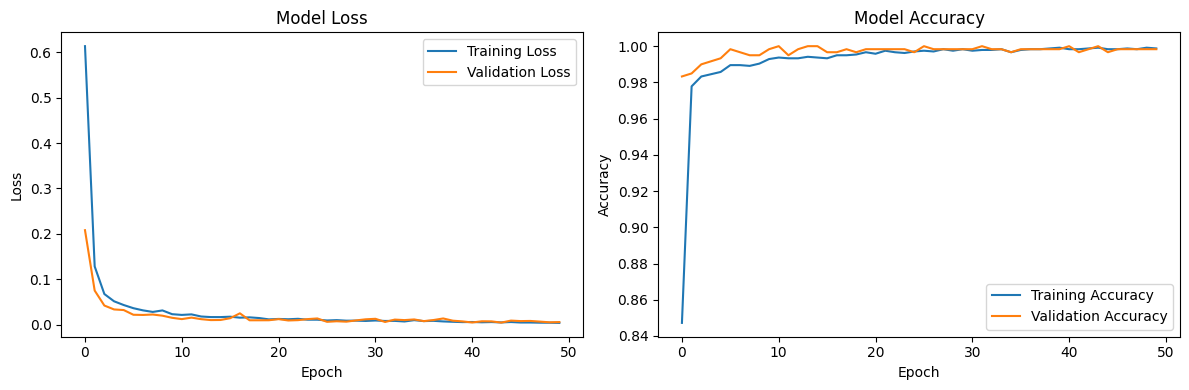

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Data preprocessing
def preprocess_data(df):
    # Extract features (all columns except filename)
    features = df.iloc[:, :-1].values

    # Create labels from filenames
    labels = []
    for name in df['filename']:
        if name.startswith('regular'):
            labels.append(0)
        elif name.startswith('irregular'):
            labels.append(1)
        elif name.startswith('afib'):
            labels.append(2)
    labels = np.array(labels)

    return features, labels

# Load and prepare data
df = pd.read_csv('output.csv')
X, y = preprocess_data(df)

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=3)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(14,)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    verbose=1
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'\nTest accuracy: {test_accuracy:.4f}')

# Save model and scaler
model.save('ecg_model.h5')
import joblib
joblib.dump(scaler, 'scaler.save')

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [100]:
md_df.head()

,sinus,bradycardia,tachycardia,brady_episode,increased_hrv,tachy_episode,atrial_flutter,atrial_fibrillation,extrasystoles_bigminy,extrasystoles_frequent,extrasystoles_isolated,extrasystoles_trigeminy,extrasystoles_big_episode,extrasystoles_trig_episode,filename
2987,0.013306,0.004125,0.017153,0.014847,0.002439,0.027897,0.427575,0.038804,0.008223,0.385157,0.031325,0.006394,0.017762,0.004992,afib_989.csv
2988,0.014234,0.015363,0.016426,0.032832,0.029599,0.040644,0.010289,0.302419,0.013874,0.269736,0.100161,0.013970,0.111586,0.028867,afib_990.csv
2989,0.008886,0.004482,0.009871,0.010134,0.034604,0.000000,0.024922,0.446735,0.005131,0.363600,0.051695,0.005281,0.026394,0.008266,afib_991.csv
2990,0.009851,0.010816,0.010770,0.011884,0.026596,0.055513,0.018057,0.461058,0.009929,0.240680,0.018259,0.011628,0.099667,0.015292,afib_992.csv
2991,0.008865,0.002468,0.003035,0.117543,0.044434,0.000000,0.008510,0.656150,0.003359,0.133761,0.006913,0.002895,0.008887,0.003180,afib_993.csv


In [103]:
# Iterate through each array in numpy_arrays and normalize it
normalized_arrays = []
for array in numpy_arrays:
    # Reshape the array to 2D for scaling
    num_samples = array.shape[0]  # Get the number of samples in the array
    reshaped_array = array.reshape(num_samples, -1)  # Reshape to 2D

    # Fit the scaler to the data and transform it
    normalized_array = scaler.fit_transform(reshaped_array)  # Normalize

    # Reshape back to the original shape
    normalized_array = normalized_array.reshape(array.shape)  # Reshape back to 3D

    normalized_arrays.append(normalized_array)  # Add to the list of normalized arrays

# Now normalized_arrays contains the list of normalized NumPy arrays